In [1]:
import numpy as np
import pandas as pd
import os
import saiph
#poetry add saiph 
#pyproject.toml avatar-python
#make install 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate
from avatars.models import ReportCreate
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters, PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters
from avatars.models import Projections
from scipy.optimize import linear_sum_assignment
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

map_color={'Regular':"lightgrey",'LSA':'teal','LSA Noised':'lightblue','LSA Noised diff length':'lightgreen','LSA boost':'gold' ,'originals':'black'}

In [2]:
patient = pd.read_csv('patient.csv').drop(columns=['Unnamed: 0'])
doctor = pd.read_csv('doctor.csv').drop(columns=['Unnamed: 0']).rename(columns={"age":"age_doctor"})
visit =  pd.read_csv('visit.csv').drop(columns=['Unnamed: 0'])

patient_to_avat = patient.drop(columns=['patient_id'])
doctor_to_avat = doctor.drop(columns=['doctor_id'])

patient_to_avat_with_visit_nb = patient.copy()
patient_to_avat_with_visit_nb['nb_visit'] = visit['patient_id'].value_counts().sort_index()
patient_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
patient_to_avat_with_visit_nb['nb_visit'] = patient_to_avat_with_visit_nb['nb_visit'].astype('int')

doctor_to_avat_with_visit_nb = doctor.copy()
doctor_to_avat_with_visit_nb['nb_visit'] = visit['doctor_id'].value_counts().sort_index()
doctor_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
doctor_to_avat_with_visit_nb['nb_visit'] = doctor_to_avat_with_visit_nb['nb_visit'].astype('int')

visit_after_bib = visit.join(
        patient.set_index("patient_id"), on="patient_id"
    )
visit_after_bib = visit_after_bib.join(
        doctor.set_index("doctor_id"), on="doctor_id"
    )
visit_after_bib_to_avat = visit_after_bib.drop(columns=['visit_id', 'patient_id', 'doctor_id'])

In [3]:

dataset_patient = client.pandas_integration.upload_dataframe(patient,
                                                             name="patient",
                                                             identifier_variables="patient_id")

dataset_patient_with_visit = client.pandas_integration.upload_dataframe(patient_to_avat_with_visit_nb,
                                                                        name="patient_with_visit",
                                                                        identifier_variables=["patient_id"])

dataset_doctor = client.pandas_integration.upload_dataframe(doctor,
                                                            name="doctor",
                                                            identifier_variables=["doctor_id"])

dataset_doctor_with_visit = client.pandas_integration.upload_dataframe(doctor_to_avat_with_visit_nb,
                                                                        name="doctor_with_visit",
                                                                        identifier_variables=["doctor_id"])

dataset_visit = client.pandas_integration.upload_dataframe(visit,
                                                          name="visit",
                                                          identifier_variables=["visit_id", "patient_id", "doctor_id"])

dataset_visit_enriched = client.pandas_integration.upload_dataframe(visit_after_bib,
                                                                    name="visit_enriched",
                                                                    identifier_variables=["visit_id", "patient_id", "doctor_id"])

In [4]:
liste_doctor=[]
liste_patient=[]

for i in range(10):
    # PATIENT
    job_patient = client.jobs.create_avatarization_job(
        AvatarizationJobCreate(
            parameters=AvatarizationParameters(k=20, dataset_id=dataset_patient.id),
        )
    )
    job_patient = client.jobs.get_avatarization_job(id=job_patient.id, timeout=100)
    avatar_patient = client.pandas_integration.download_dataframe(job_patient.result.sensitive_unshuffled_avatars_datasets.id)

    job_patient_with_visit = client.jobs.create_avatarization_job(
        AvatarizationJobCreate(
            parameters=AvatarizationParameters(k=20, dataset_id=dataset_patient_with_visit.id),
        )
    )
    job_patient_with_visit = client.jobs.get_avatarization_job(id=job_patient_with_visit.id, timeout=100)
    avatar_patient_with_visit = client.pandas_integration.download_dataframe(job_patient_with_visit.result.sensitive_unshuffled_avatars_datasets.id)



    # DOCTOR
    job_doctor = client.jobs.create_avatarization_job(
        AvatarizationJobCreate(
            parameters=AvatarizationParameters(k=10, dataset_id=dataset_doctor.id),
        )
    )
    job_doctor = client.jobs.get_avatarization_job(id=job_doctor.id, timeout=100)
    avatar_doctor = client.pandas_integration.download_dataframe(job_doctor.result.sensitive_unshuffled_avatars_datasets.id)

    job_doctor_with_visit = client.jobs.create_avatarization_job(
        AvatarizationJobCreate(
            parameters=AvatarizationParameters(k=10, dataset_id=dataset_doctor_with_visit.id),
        )
    )
    job_doctor_with_visit = client.jobs.get_avatarization_job(id=job_doctor_with_visit.id, timeout=100)
    avatar_doctor_with_visit = client.pandas_integration.download_dataframe(job_doctor_with_visit.result.sensitive_unshuffled_avatars_datasets.id)

    #VISIT
    job_visit = client.jobs.create_avatarization_job(
        AvatarizationJobCreate(
            parameters=AvatarizationParameters(k=10, dataset_id=dataset_visit_enriched.id),
        )
    )
    job_visit = client.jobs.get_avatarization_job(id=job_visit.id, timeout=100)
    avatar_visit = client.pandas_integration.download_dataframe(job_visit.result.sensitive_unshuffled_avatars_datasets.id)

    # PATIENT

    model_patient = saiph.fit(patient_to_avat)
    coord_patient_ori = saiph.transform(patient_to_avat, model_patient)
    coord_patient_avat = saiph.transform(avatar_patient, model_patient)
    coord_patient_avat_visit = saiph.transform(avatar_patient_with_visit.drop(columns=['nb_visit']), model_patient)

    avatar_patient['patient_id'] = list(range(len(avatar_patient)))
    avatar_patient_with_visit['patient_id'] = list(range(len(avatar_patient_with_visit)))


    # DOCTOR

    model_doctor = saiph.fit(doctor_to_avat)
    coord_doctor_ori = saiph.transform(doctor_to_avat, model_doctor)
    coord_doctor_avat = saiph.transform(avatar_doctor, model_doctor)
    coord_doctor_avat_visit = saiph.transform(avatar_doctor_with_visit.drop(columns=['nb_visit']), model_doctor)

    avatar_doctor['doctor_id'] = list(range(len(avatar_doctor)))
    avatar_doctor_with_visit['doctor_id'] = list(range(len(avatar_doctor_with_visit)))

    # VISIT

    model_visit = saiph.fit(visit_after_bib_to_avat)
    coord_visit_enriched_ori = saiph.transform(visit_after_bib_to_avat, model_visit)
    coord_visit_enriched_avat = saiph.transform(avatar_visit, model_visit)

    coord_patient_in_visit_avatars = saiph.transform(avatar_visit[patient_to_avat.columns], model_patient)
    #coord_patient_in_visit_origins = saiph.transform(visit_after_bib_to_avat[patient_to_avat.columns], model_patient)
    coord_doctor_in_visit_avatars = saiph.transform(avatar_visit[doctor_to_avat.columns], model_doctor)

    avatar_visit['visit_id'] = list(range(len(avatar_visit)))

    avatar_patient_visit = avatar_patient_with_visit.drop(columns=['nb_visit'])
    avatar_doctor_visit = avatar_doctor_with_visit.drop(columns=['nb_visit'])

    ### PATIENT

    original_visit_per_patient = dict(visit['patient_id'].value_counts())
    avatar_visit_per_patient = dict(avatar_patient_with_visit['nb_visit'])

    #regular
    distances_regular = distance_matrix(coord_patient_in_visit_avatars, coord_patient_avat)
    #closest_id_regular = distances_regular.argmin(axis=1)
    k_closest_id = [
    np.nonzero(distances_regular[i] == distances_regular[i].min()) for i in range(len(distances_regular))
    ]
    closest_id_regular = [np.random.choice(k_closest_id[i][0]) for i in range(len(distances_regular))]
    closest_parent_regular = patient.loc[closest_id_regular, "patient_id"]
    avatar_visit['patient_id_regular'] = list(closest_parent_regular)

    #LSA
    tmp_dfs = []
    tmp_dfs_boost = []
    cpt=1
    for id, n in original_visit_per_patient.items():
            tmp_df = avatar_patient[avatar_patient["patient_id"] == id].sample(n=n, replace=True, random_state=1)
            tmp_dfs.append(tmp_df)
            tmp_df_boost = avatar_patient[avatar_patient["patient_id"] == id].sample(n=n+cpt, replace=True, random_state=1)
            tmp_dfs_boost.append(tmp_df_boost)

    table_patient_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
    coord_patient_duplicated = saiph.transform(table_patient_with_duplicates, model_patient)
    distances_lsa = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated)
    row_ind, col_ind = linear_sum_assignment(distances_lsa)
    closest_parent_lsa = table_patient_with_duplicates['patient_id'].loc[col_ind]
    avatar_visit['patient_id_lsa'] = list(closest_parent_lsa)

    #LSA BOOST
    table_patient_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
    coord_patient_duplicated_boost = saiph.transform(table_patient_with_duplicates_boost, model_patient)
    distances_lsa_boost = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_boost)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
    closest_parent_lsa_boost = table_patient_with_duplicates_boost['patient_id'].loc[col_ind]
    avatar_visit['patient_id_lsa_boost']=np.NaN
    avatar_visit['patient_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)


    #LSA Noised
    tmp_dfs = []
    for id, n in avatar_visit_per_patient.items():
            tmp_df = avatar_patient_visit[avatar_patient_visit["patient_id"] == id].sample(n=n, replace=True, random_state=1)
            tmp_dfs.append(tmp_df)
    table_patient_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
    table_patient_with_duplicates_noised2=table_patient_with_duplicates_noised.copy()

    if len(table_patient_with_duplicates_noised) > len(visit):
        table_patient_with_duplicates_noised= table_patient_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
    else:
        table_patient_with_duplicates_noised = table_patient_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
    coord_patient_duplicated_noised = saiph.transform(table_patient_with_duplicates_noised, model_patient)
    distances_lsa_noised = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_noised)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
    closest_parent_lsa_noised = table_patient_with_duplicates_noised['patient_id'].loc[col_ind]
    avatar_visit['patient_id_lsa_noised'] = list(closest_parent_lsa_noised)

    ## LSA NOISED DIFF LENGTH 

    coord_patient_duplicated_noised2 = saiph.transform(table_patient_with_duplicates_noised2, model_patient)
    distances_lsa_noised_diff_length = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_noised2)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)

    closest_parent_lsa_noised_diff_length = table_patient_with_duplicates_noised2['patient_id'].loc[col_ind]
    avatar_visit['patient_id_lsa_noised_diff_length']=np.NaN
    avatar_visit['patient_id_lsa_noised_diff_length'].loc[row_ind]=list(closest_parent_lsa_noised_diff_length)


    ### DOCTOR
    original_visit_per_doctor = dict(visit['doctor_id'].value_counts())
    avatar_visit_per_doctor = dict(avatar_doctor_with_visit['nb_visit'])


    #regular
    distances_regular = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_avat)
    #closest_id_regular = distances_regular.argmin(axis=1)
    k_closest_id = [
    np.nonzero(distances_regular[i] == distances_regular[i].min()) for i in range(len(distances_regular))
    ]
    closest_id_regular = [np.random.choice(k_closest_id[i][0]) for i in range(len(distances_regular))]
    closest_parent_regular = doctor.loc[closest_id_regular, "doctor_id"]
    avatar_visit['doctor_id_regular'] = list(closest_parent_regular)

    #lsa 
    tmp_dfs = []
    tmp_dfs_boost = []
    for id, n in original_visit_per_doctor.items():
            tmp_df = avatar_doctor[avatar_doctor["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
            tmp_dfs.append(tmp_df)
            tmp_df_boost = avatar_doctor[avatar_doctor["doctor_id"] == id].sample(n=n+cpt, replace=True, random_state=1)
            tmp_dfs_boost.append(tmp_df_boost)
    

    table_doctor_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
    coord_doctor_duplicated = saiph.transform(table_doctor_with_duplicates, model_doctor)
    distances_lsa = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated)
    row_ind, col_ind = linear_sum_assignment(distances_lsa)
    closest_parent_lsa = table_doctor_with_duplicates['doctor_id'].loc[col_ind]
    avatar_visit['doctor_id_lsa'] = list(closest_parent_lsa)


    #LSA BOOST
    table_doctor_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
    coord_doctor_duplicated_boost = saiph.transform(table_doctor_with_duplicates_boost, model_doctor)
    distances_lsa_boost = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_boost)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
    closest_parent_lsa_boost = table_doctor_with_duplicates_boost['doctor_id'].loc[col_ind]
    avatar_visit['doctor_id_lsa_boost']=np.NaN
    avatar_visit['doctor_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)


    #lsa noised
    tmp_dfs = []
    for id, n in avatar_visit_per_doctor.items():
            tmp_df = avatar_doctor_visit[avatar_doctor_visit["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
            tmp_dfs.append(tmp_df)
    table_doctor_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
    table_doctor_with_duplicates_noised2 = table_doctor_with_duplicates_noised.copy()

    if len(table_doctor_with_duplicates_noised) > len(visit):
        table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
    else:
        table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
    coord_doctor_duplicated_noised = saiph.transform(table_doctor_with_duplicates_noised, model_doctor)
    distances_lsa_noised = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_noised)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
    closest_parent_lsa_noised = table_doctor_with_duplicates_noised['doctor_id'].loc[col_ind]
    avatar_visit['doctor_id_lsa_noised'] = list(closest_parent_lsa_noised)

    ## LSA NOISED DIFF LENGTH 

    coord_doctor_duplicated_noised2 = saiph.transform(table_doctor_with_duplicates_noised2, model_doctor)
    distances_lsa_noised_diff_length = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_noised2)
    row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)

    closest_parent_lsa_noised_diff_length = table_doctor_with_duplicates_noised2['doctor_id'].loc[col_ind]
    avatar_visit['doctor_id_lsa_noised_diff_length']=np.NaN
    avatar_visit['doctor_id_lsa_noised_diff_length'].loc[row_ind]= list(closest_parent_lsa_noised_diff_length)

    cpt+=1
    liste_doctor.append(avatar_visit[['doctor_id_regular','doctor_id_lsa','doctor_id_lsa_boost','doctor_id_lsa_noised','doctor_id_lsa_noised_diff_length']])
    liste_patient.append(avatar_visit[['patient_id_regular','patient_id_lsa','patient_id_lsa_boost','patient_id_lsa_noised','patient_id_lsa_noised_diff_length']])


AttributeError: 'NoneType' object has no attribute 'sensitive_unshuffled_avatars_datasets'

nb_patient :  111
nb_patient :  119
nb_patient :  119
nb_patient :  117
nb_patient :  118
nb_patient :  118
nb_patient :  121
nb_patient :  102
nb_patient :  113
nb_patient :  116


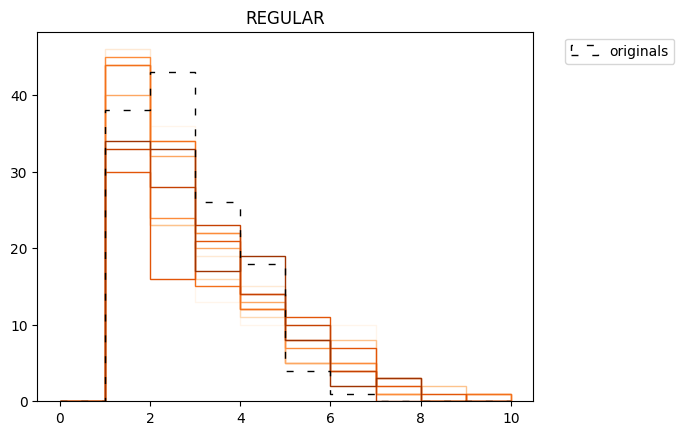

In [ ]:
## REGULAR
cpt=0
for i in liste_patient:
    print("nb_patient : ",i['patient_id_regular'].nunique())
    plt.hist(np.array(i['patient_id_regular'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10)) #color=map_color['Regular'])
    cpt+=1
plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('REGULAR')
plt.show()

nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130
nb_patient :  130


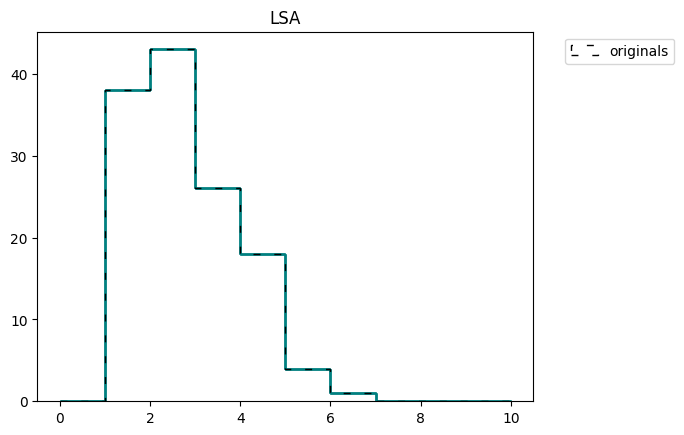

In [ ]:
for i in liste_patient:
    print("nb_patient : ",i['patient_id_lsa'].nunique())
    plt.hist(np.array(i['patient_id_lsa'].value_counts()), bins=list(range(11)), histtype="step",color=map_color['LSA'])
plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA")
plt.show()

nb_patient :  113
nb_patient :  118
nb_patient :  120
nb_patient :  117
nb_patient :  114
nb_patient :  117
nb_patient :  119
nb_patient :  109
nb_patient :  113
nb_patient :  113


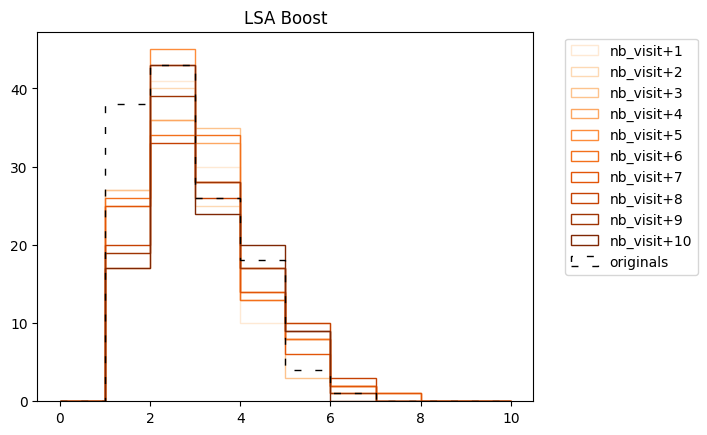

In [ ]:
cpt=1
for i in liste_patient:
    print("nb_patient : ",i['patient_id_lsa_boost'].nunique())
    plt.hist(np.array(i['patient_id_lsa_boost'].value_counts()), bins=list(range(11)), histtype="step",label=f"nb_visit+{cpt}",color=plt.cm.Oranges(cpt/10))
    cpt+=1

plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA Boost")
plt.show()

nb_patient :  142
nb_patient :  118
nb_patient :  117
nb_patient :  144
nb_patient :  111
nb_patient :  114
nb_patient :  142
nb_patient :  115
nb_patient :  111
nb_patient :  119


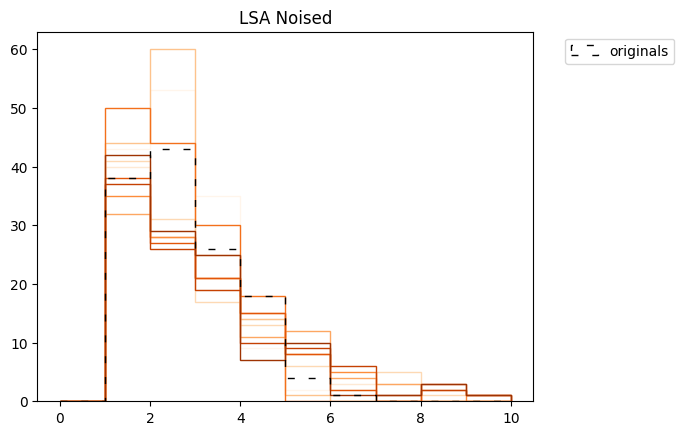

In [ ]:
cpt=0
for i in liste_patient:
    print("nb_patient : ",i['patient_id_lsa_noised'].nunique())
    plt.hist(np.array(i['patient_id_lsa_noised'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10))#color=map_color['LSA Noised'])
    cpt+=1
plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("LSA Noised")
plt.show()

nb_patient :  141   nb_visit :  300
nb_patient :  144   nb_visit :  287
nb_patient :  145   nb_visit :  296
nb_patient :  144   nb_visit :  300
nb_patient :  139   nb_visit :  294
nb_patient :  140   nb_visit :  285
nb_patient :  142   nb_visit :  300
nb_patient :  141   nb_visit :  295
nb_patient :  142   nb_visit :  292
nb_patient :  146   nb_visit :  293


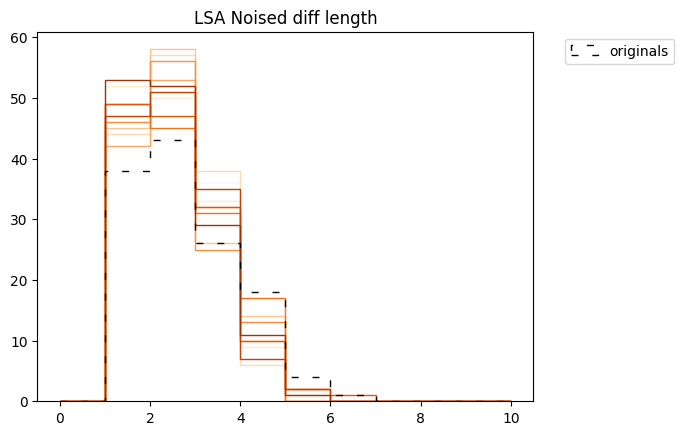

In [ ]:
cpt=0
for i in liste_patient:
    print("nb_patient : ",i['patient_id_lsa_noised_diff_length'].nunique(), "  nb_visit : ",i['patient_id_lsa_noised_diff_length'].count())
    plt.hist(np.array(i['patient_id_lsa_noised_diff_length'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10))#color=map_color['LSA Noised diff length'])
    cpt+=1
plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA Noised diff length")
plt.show()

nb_doctor :  43
nb_doctor :  47
nb_doctor :  44
nb_doctor :  44
nb_doctor :  47
nb_doctor :  45
nb_doctor :  45
nb_doctor :  44
nb_doctor :  45
nb_doctor :  47


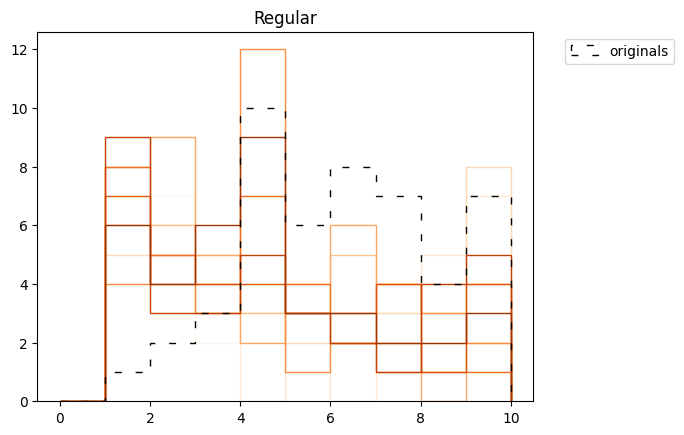

In [ ]:
cpt=0
for i in liste_doctor:
    plt.hist(np.array(i['doctor_id_regular'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10))# color=map_color['Regular'])
    print("nb_doctor : ",i['doctor_id_regular'].nunique())
    cpt+=1
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Regular")
plt.show()

nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50


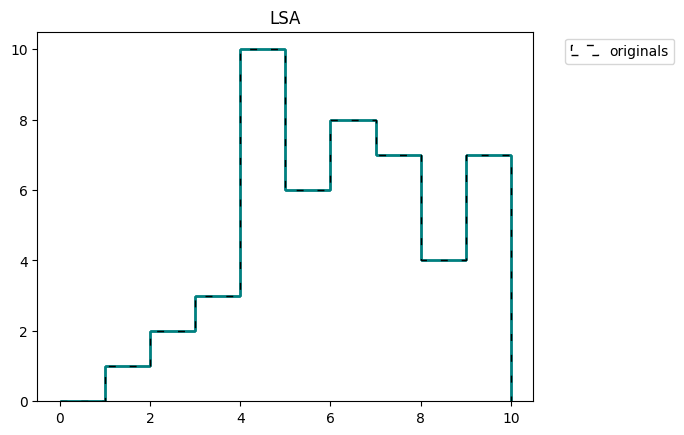

In [ ]:
for i in liste_doctor:
    print("nb_doctor : ",i['doctor_id_lsa'].nunique())
    plt.hist(np.array(i['doctor_id_lsa'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA'])
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA")
plt.show()

nb_doctor :  48
nb_doctor :  49
nb_doctor :  47
nb_doctor :  49
nb_doctor :  49
nb_doctor :  49
nb_doctor :  48
nb_doctor :  49
nb_doctor :  50
nb_doctor :  50


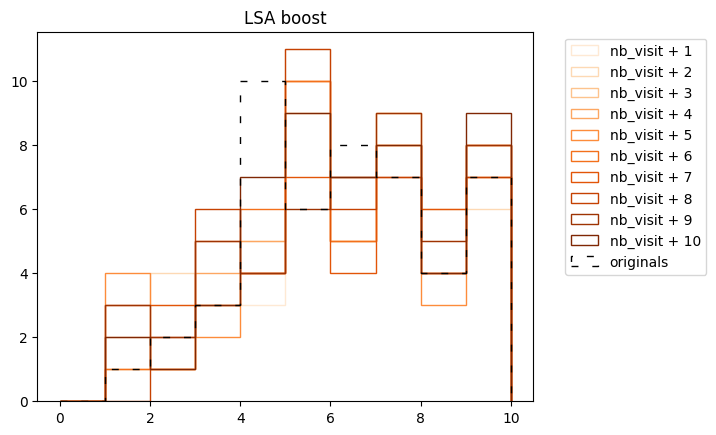

In [ ]:
cpt=1
for i in liste_doctor:
    print("nb_doctor : ",i['doctor_id_lsa_boost'].nunique())
    plt.hist(np.array(i['doctor_id_lsa_boost'].value_counts()), bins=list(range(11)), histtype="step", color=plt.cm.Oranges(cpt/10), label=f"nb_visit + {cpt}")
    cpt+=1
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA boost")
plt.show()

nb_doctor :  50
nb_doctor :  49
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50
nb_doctor :  49
nb_doctor :  48
nb_doctor :  50
nb_doctor :  50
nb_doctor :  50


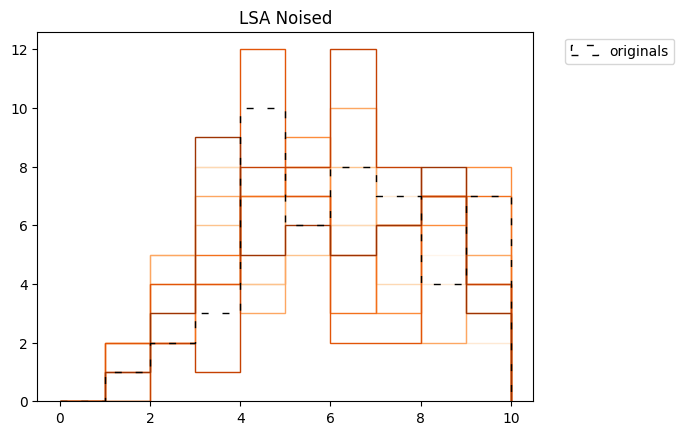

In [ ]:
cpt=0
for i in liste_doctor:
    print("nb_doctor : ",i['doctor_id_lsa_noised'].nunique())
    plt.hist(np.array(i['doctor_id_lsa_noised'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10)) #color=map_color['LSA Noised'])
    cpt+=1
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA Noised")
plt.show()


nb_doctor :  50   nb_visit :  300
nb_doctor :  50   nb_visit :  289
nb_doctor :  50   nb_visit :  288
nb_doctor :  50   nb_visit :  292
nb_doctor :  50   nb_visit :  298
nb_doctor :  50   nb_visit :  288
nb_doctor :  50   nb_visit :  291
nb_doctor :  50   nb_visit :  287
nb_doctor :  50   nb_visit :  300
nb_doctor :  50   nb_visit :  299


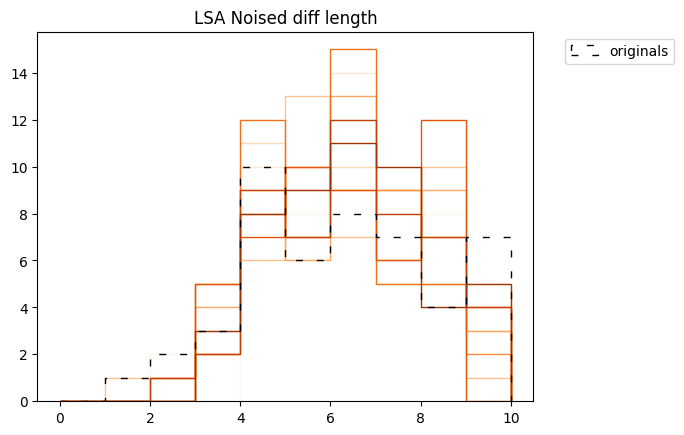

In [ ]:
cpt=0
for i in liste_doctor:
    print("nb_doctor : ",i['doctor_id_lsa_noised_diff_length'].nunique(), "  nb_visit : ",i['doctor_id_lsa_noised_diff_length'].count())
    plt.hist(np.array(i['doctor_id_lsa_noised_diff_length'].value_counts()), bins=list(range(11)), histtype="step",color=plt.cm.Oranges(cpt/10)) #color=map_color['LSA Noised diff length'])
    cpt+=1
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("LSA Noised diff length")
plt.show()
